# Asignación III

**DNNs**  
Fecha: 4 de octubre de 2025

**Resumen**

El objetivo es repasar algunos resultados básicos relacionados con redes neuronales. Por favor suban sus soluciones en un archivo comprimido a Classroom antes del 14 de octubre.

---


In [1]:
# Imports y configuración global (plantilla)
import os
import math
import random
import kaggle
import numpy as np
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = get_device(); set_seed(42)

## Problema 1

Considere el conjunto de datos de [1]. Haga un script en PyTorch para resolver el problema de regresión asociado con la predicción del consumo de combustible. Debe usar un único modelo DNN para predecir tanto el consumo en ciudad como en carretera.

- Escriba todas las suposiciones y las operaciones de preprocesamiento de datos que realice.
- Escriba los hiperparámetros del modelo y de la optimización que elija y explique por qué los seleccionó de esa manera.
- Incluya una gráfica del error vs iteraciones y una gráfica de la solución.

Fuente: link: https://www.kaggle.com/datasets/rinichristy/2022-fuel-consumption-ratings



In [2]:
import polars as pl
import os
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("rinichristy/2022-fuel-consumption-ratings")
csv_file = os.path.join(path, "MY2022 Fuel Consumption Ratings.csv")

df = pl.read_csv(csv_file)
df.head()

Model Year,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating
i64,str,str,str,f64,i64,str,str,f64,f64,f64,i64,i64,i64,i64
2022,"""Acura""","""ILX""","""Compact""",2.4,4,"""AM8""","""Z""",9.9,7.0,8.6,33,200,6,3
2022,"""Acura""","""MDX SH-AWD""","""SUV: Small""",3.5,6,"""AS10""","""Z""",12.6,9.4,11.2,25,263,4,5
2022,"""Acura""","""RDX SH-AWD""","""SUV: Small""",2.0,4,"""AS10""","""Z""",11.0,8.6,9.9,29,232,5,6
2022,"""Acura""","""RDX SH-AWD A-SPEC""","""SUV: Small""",2.0,4,"""AS10""","""Z""",11.3,9.1,10.3,27,242,5,6
2022,"""Acura""","""TLX SH-AWD""","""Compact""",2.0,4,"""AS10""","""Z""",11.2,8.0,9.8,29,230,5,7


In [3]:
df.sample(10)

Model Year,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating
i64,str,str,str,f64,i64,str,str,f64,f64,f64,i64,i64,i64,i64
2022,"""Cadillac""","""CT5 AWD""","""Mid-size""",3.0,6,"""AS10""","""Z""",12.8,9.1,11.1,25,260,4,5
2022,"""Ford""","""Bronco Black Diamond 4WD""","""SUV: Small""",2.3,4,"""M7""","""X""",13.8,12.4,13.2,21,310,3,5
2022,"""GMC""","""Acadia""","""SUV: Standard""",3.6,6,"""A9""","""X""",12.3,8.8,10.7,26,252,5,6
2022,"""BMW""","""X3 M Competition""","""SUV: Small""",3.0,6,"""AS8""","""Z""",15.7,11.7,13.9,20,323,3,3
2022,"""Mercedes-Benz""","""AMG E 53 4MATIC+ Coupe""","""Subcompact""",3.0,6,"""A9""","""Z""",11.7,8.4,10.2,28,239,5,6
2022,"""Chevrolet""","""Suburban 4WD""","""SUV: Standard""",3.0,6,"""A10""","""D""",11.7,9.0,10.5,27,281,4,3
2022,"""Mazda""","""Mazda3 5-Door Turbo 4WD""","""Mid-size""",2.5,4,"""AS6""","""X""",10.1,7.5,8.9,32,209,5,5
2022,"""BMW""","""M440i xDrive Cabriolet""","""Subcompact""",3.0,6,"""AS8""","""Z""",10.4,7.4,9.1,31,211,5,5
2022,"""Toyota""","""Sienna AWD""","""Minivan""",2.5,4,"""AV""","""X""",6.8,6.6,6.7,42,158,7,7


### Análisis Exploratorio de los Datos

Al revisar el conjunto de datos, se observa que **no existen valores nulos** en ninguna columna 

Las **columnas numéricas** (`Int64`, `Float64`) incluyen variables como:
- Año del vehículo
- Tamaño del motor
- Número de cilindros
- Consumo de combustible (en ciudad, carretera, combinado)
- Emisiones de CO₂

Las **columnas categóricas** (`String`) corresponden a:
- Marca
- Modelo
- Clase de vehículo
- Transmisión
- Tipo de combustible

Estas variables representan información cualitativa. Para utilizarlas en modelos lineales (como regresión logística o lineal), es necesario transformarlas mediante **One Hot Encoding**. 


**Model Year** por otra parte es constante y no aporta información relevante al modelo, por lo que se decide eliminarla del dataset.

Además, Fuel Consumption(Comb (L/100 km)) y Fuel Consumption(Comb (mpg)) son variables derivadas de los objetivos de consumo de combustible en ciudad y carretera, por lo que también se eliminan del dataset.


In [4]:
import polars as pl

categorical_cols = ['Make', 'Vehicle Class', 'Transmission', 'Fuel Type']

for col in categorical_cols:
    uniques = df.select(col).unique()
    print(f"Valores únicos para '{col}':")
    print(uniques)
    print('-' * 40)


Valores únicos para 'Make':
shape: (39, 1)
┌─────────────┐
│ Make        │
│ ---         │
│ str         │
╞═════════════╡
│ Lamborghini │
│ Bugatti     │
│ Chrysler    │
│ Mazda       │
│ Honda       │
│ …           │
│ Land Rover  │
│ Chevrolet   │
│ Alfa Romeo  │
│ Ram         │
│ Kia         │
└─────────────┘
----------------------------------------
Valores únicos para 'Vehicle Class':
shape: (14, 1)
┌─────────────────────────┐
│ Vehicle Class           │
│ ---                     │
│ str                     │
╞═════════════════════════╡
│ Mid-size                │
│ Pickup truck: Standard  │
│ Pickup truck: Small     │
│ Full-size               │
│ Station wagon: Mid-size │
│ …                       │
│ Two-seater              │
│ Compact                 │
│ Minivan                 │
│ Station wagon: Small    │
│ SUV: Standard           │
└─────────────────────────┘
----------------------------------------
Valores únicos para 'Transmission':
shape: (23, 1)
┌──────────────┐
│ Trans

In [5]:
df.select(pl.col("Fuel Consumption (City (L/100 km)"))

Fuel Consumption (City (L/100 km)
f64
9.9
12.6
11.0
11.3
11.2
…
10.7
10.5
11.0


Por lo visto, la columna modelo es extremada mente grande en cuanto a valores unico
como para ser considerada en el onehot, la mejor opción es eliminarla del dataset.

In [6]:
df = df.drop(["Model", "Model Year", "Fuel Consumption(Comb (L/100 km))", "Fuel Consumption(Comb (mpg))"])  # Eliminar la columna 'Model' y 'Model Year' debido a su alta cardinalidad

In [7]:
# Importar onehotencoder
from sklearn.preprocessing import OneHotEncoder

# Hacer one hot encoding a las columnas categóricas
categorical_cols = ['Make', 'Vehicle Class', 'Transmission', 'Fuel Type']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar multicolinealidad
encoded_data = encoder.fit_transform(df.select(categorical_cols).to_numpy())
encoded_df = pl.DataFrame(encoded_data, schema=encoder.get_feature_names_out(categorical_cols).tolist())

In [8]:

numeric_cols = [col for col in df.columns if col not in categorical_cols]
df_numeric = df.select(numeric_cols)
df_merged = pl.concat([df_numeric, encoded_df], how="horizontal")
df_merged.head()

Engine Size(L),Cylinders,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),CO2 Emissions(g/km),CO2 Rating,Smog Rating,Make_Alfa Romeo,Make_Aston Martin,Make_Audi,Make_BMW,Make_Bentley,Make_Bugatti,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ford,Make_GMC,Make_Genesis,Make_Honda,Make_Hyundai,Make_Infiniti,Make_Jaguar,Make_Jeep,Make_Kia,Make_Lamborghini,Make_Land Rover,Make_Lexus,Make_Lincoln,Make_MINI,Make_Maserati,Make_Mazda,Make_Mercedes-Benz,Make_Mitsubishi,…,Vehicle Class_Mid-size,Vehicle Class_Minicompact,Vehicle Class_Minivan,Vehicle Class_Pickup truck: Small,Vehicle Class_Pickup truck: Standard,Vehicle Class_SUV: Small,Vehicle Class_SUV: Standard,Vehicle Class_Special purpose vehicle,Vehicle Class_Station wagon: Mid-size,Vehicle Class_Station wagon: Small,Vehicle Class_Subcompact,Vehicle Class_Two-seater,Transmission_A6,Transmission_A7,Transmission_A8,Transmission_A9,Transmission_AM6,Transmission_AM7,Transmission_AM8,Transmission_AS10,Transmission_AS5,Transmission_AS6,Transmission_AS7,Transmission_AS8,Transmission_AS9,Transmission_AV,Transmission_AV1,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel Type_E,Fuel Type_X,Fuel Type_Z
f64,i64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.4,4,9.9,7.0,200,6,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3.5,6,12.6,9.4,263,4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2.0,4,11.0,8.6,232,5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2.0,4,11.3,9.1,242,5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2.0,4,11.2,8.0,230,5,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


###  Creación del modelo de la Ciudad

In [9]:
# Split data
from sklearn.model_selection import train_test_split

# Nota: mantener el mismo nombre de columna usado anteriormente
X = df_merged.drop("Fuel Consumption (City (L/100 km)")
y = df_merged["Fuel Consumption (City (L/100 km)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convertir a tensores y asegurar la forma (n_samples, 1) para y
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train.to_numpy().reshape(-1, 1), dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32).to(device)


In [10]:
class DNN(nn.Module):
    def __init__(self, n):
        super(DNN, self).__init__()
        
        # Número de capas (L = número de elementos en n - 1)
        self.L = len(n) - 1
        
        # Función de activación: guardamos la clase, instanciamos por capa
        #actcls = nn.Sigmoid
        actcls = nn.ReLU
        #actcls = nn.Tanh
        
        layers = list()
        # Construye las capas ocultas con su función de activación
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))  # Capa lineal
            layers.append((f'actfunc_{i+1}', actcls()))          # Activación (nueva instancia por capa)
        
        # Última capa (sin activación)
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))  # Secuencia ordenada de capas
        
    def forward(self, x):
        # Propagación hacia adelante: aplica todas las capas secuencialmente
        return self.layers(x)

# Custom Dataset


class my_DL(Dataset):
    
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.y)

my_train_data = my_DL(X_train, y_train)

# Batches
batch_size = 32
print(len(X_train), X_train.shape[0] % batch_size)
train_DL = DataLoader(dataset=my_train_data, batch_size=batch_size, shuffle=True, drop_last=False)
print(len(train_DL))

756 20
24


In [11]:
# Creating NN model
input_size = X_train.shape[1]
# For regression the output size must be 1
output_size = 1

# Use a small hidden layer as starting point
#model = DNN(n=[input_size, 20, output_size]).to(device)
# alternative architectures:
model = DNN(n=[input_size, 50, 20, output_size]).to(device)
# model = DNN(n=[input_size, output_size]).to(device)


In [12]:
learning_rate = 0.01
num_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

In [13]:
def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_hat_train = model(X_train)
        loss_train = criterion(y_hat_train, y_train)
        loss_train.backward()
        optimizer.step()
        train_losses[epoch] = loss_train.item()
        
        # Evaluation phase
        model.eval()
        with torch.no_grad():
            y_hat_test = model(X_test)
            loss_test = criterion(y_hat_test, y_test)
            test_losses[epoch] = loss_test.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}')
    
    # Plot losses
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Train/Test Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, test_losses

Epoch [10/500], Train Loss: 44.0511, Test Loss: 26.8798
Epoch [20/500], Train Loss: 5.1322, Test Loss: 3.8406
Epoch [30/500], Train Loss: 4.6756, Test Loss: 3.4584
Epoch [40/500], Train Loss: 1.6248, Test Loss: 1.3979
Epoch [50/500], Train Loss: 0.8801, Test Loss: 1.0835
Epoch [60/500], Train Loss: 0.5108, Test Loss: 0.9268
Epoch [70/500], Train Loss: 0.3928, Test Loss: 0.7024
Epoch [80/500], Train Loss: 0.3195, Test Loss: 0.6466
Epoch [90/500], Train Loss: 0.2592, Test Loss: 0.5650
Epoch [100/500], Train Loss: 0.2161, Test Loss: 0.5323
Epoch [110/500], Train Loss: 0.1896, Test Loss: 0.5043
Epoch [120/500], Train Loss: 0.1699, Test Loss: 0.4839
Epoch [130/500], Train Loss: 0.1539, Test Loss: 0.4634
Epoch [140/500], Train Loss: 0.1415, Test Loss: 0.4497
Epoch [150/500], Train Loss: 0.1312, Test Loss: 0.4345
Epoch [160/500], Train Loss: 0.1228, Test Loss: 0.4229
Epoch [170/500], Train Loss: 0.1148, Test Loss: 0.4117
Epoch [180/500], Train Loss: 0.1083, Test Loss: 0.4036
Epoch [190/500], 

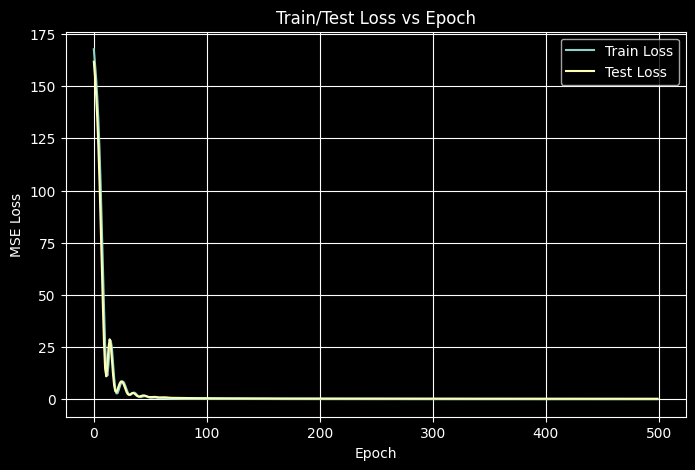

In [14]:
# Entrenar modelo e imprimir pérdidas
train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)
train_losses, test_losses = train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses)


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_regression_metrics(y_true, y_pred):
    # Ensure numpy 1D arrays
    y_true_np = y_true.cpu().numpy().reshape(-1)
    y_pred_np = y_pred.cpu().numpy().reshape(-1)
    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)
    return rmse, mae, r2

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).cpu().numpy().reshape(-1)
    y_test_pred = model(X_test).cpu().numpy().reshape(-1)

# y_train is a tensor with shape (n,1); convert to 1D numpy
train_rmse, train_mae, r2_train = compute_regression_metrics(y_train, torch.tensor(y_train_pred))
test_rmse, test_mae, r2_test = compute_regression_metrics(y_test, torch.tensor(y_test_pred))

print(f'Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {r2_train:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {r2_test:.4f}')


Train RMSE: 0.1816, MAE: 0.1215, R2: 0.9972
Test RMSE: 0.5206, MAE: 0.3422, R2: 0.9776


###  Creación del modelo de la Carretera

In [16]:
# Split data
from sklearn.model_selection import train_test_split

X = df_merged.drop("Fuel Consumption(Hwy (L/100 km))")
y = df_merged["Fuel Consumption(Hwy (L/100 km))"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convertir a tensores y asegurar la forma (n_samples, 1) para y
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train.to_numpy().reshape(-1, 1), dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32).to(device)

class DNN(nn.Module):
    def __init__(self, n):
        super(DNN, self).__init__()
        
        # Número de capas (L = número de elementos en n - 1)
        self.L = len(n) - 1
        
        # Función de activación: guardamos la clase, instanciamos por capa
        #actcls = nn.Sigmoid
        actcls = nn.ReLU
        #actcls = nn.Tanh
        
        layers = list()
        # Construye las capas ocultas con su función de activación
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))  # Capa lineal
            layers.append((f'actfunc_{i+1}', actcls()))          # Activación (nueva instancia por capa)
        
        # Última capa (sin activación)
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))  # Secuencia ordenada de capas
        
    def forward(self, x):
        # Propagación hacia adelante: aplica todas las capas secuencialmente
        return self.layers(x)

# Custom Dataset


class my_DL(Dataset):
    
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.y)

my_train_data = my_DL(X_train, y_train)

# Batches
batch_size = 32
print(len(X_train), X_train.shape[0] % batch_size)
train_DL = DataLoader(dataset=my_train_data, batch_size=batch_size, shuffle=True, drop_last=False)
print(len(train_DL))

756 20
24


In [17]:
# Creating NN model
input_size = X_train.shape[1]
# For regression the output size must be 1
output_size = 1

# Use a small hidden layer as starting point
#model = DNN(n=[input_size, 20, output_size]).to(device)
# alternative architectures:
model = DNN(n=[input_size, 50, 20, output_size]).to(device)
# model = DNN(n=[input_size, output_size]).to(device)


In [18]:
learning_rate = 0.01
num_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

In [19]:
def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_hat_train = model(X_train)
        loss_train = criterion(y_hat_train, y_train)
        loss_train.backward()
        optimizer.step()
        train_losses[epoch] = loss_train.item()
        
        # Evaluation phase
        model.eval()
        with torch.no_grad():
            y_hat_test = model(X_test)
            loss_test = criterion(y_hat_test, y_test)
            test_losses[epoch] = loss_test.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}')
    
    # Plot losses
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Train/Test Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, test_losses

Epoch [10/500], Train Loss: 25.9447, Test Loss: 16.4151
Epoch [20/500], Train Loss: 4.1174, Test Loss: 2.9411
Epoch [30/500], Train Loss: 3.2301, Test Loss: 3.0960
Epoch [40/500], Train Loss: 1.2832, Test Loss: 1.0788
Epoch [50/500], Train Loss: 0.5912, Test Loss: 0.8490
Epoch [60/500], Train Loss: 0.3378, Test Loss: 0.5305
Epoch [30/500], Train Loss: 3.2301, Test Loss: 3.0960
Epoch [40/500], Train Loss: 1.2832, Test Loss: 1.0788
Epoch [50/500], Train Loss: 0.5912, Test Loss: 0.8490
Epoch [60/500], Train Loss: 0.3378, Test Loss: 0.5305
Epoch [70/500], Train Loss: 0.2255, Test Loss: 0.4773
Epoch [80/500], Train Loss: 0.1815, Test Loss: 0.4207
Epoch [90/500], Train Loss: 0.1554, Test Loss: 0.3885
Epoch [100/500], Train Loss: 0.1382, Test Loss: 0.3646
Epoch [110/500], Train Loss: 0.1259, Test Loss: 0.3445
Epoch [120/500], Train Loss: 0.1166, Test Loss: 0.3320
Epoch [130/500], Train Loss: 0.1092, Test Loss: 0.3191
Epoch [70/500], Train Loss: 0.2255, Test Loss: 0.4773
Epoch [80/500], Train 

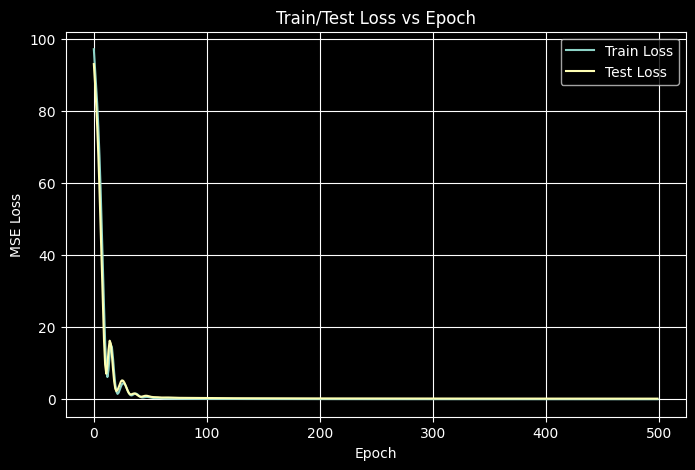

In [20]:
# Entrenar modelo e imprimir pérdidas
train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)
train_losses, test_losses = train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses)


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_regression_metrics(y_true, y_pred):
    # Ensure numpy 1D arrays
    y_true_np = y_true.cpu().numpy().reshape(-1)
    y_pred_np = y_pred.cpu().numpy().reshape(-1)
    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)
    return rmse, mae, r2

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).cpu().numpy().reshape(-1)
    y_test_pred = model(X_test).cpu().numpy().reshape(-1)

# y_train is a tensor with shape (n,1); convert to 1D numpy
train_rmse, train_mae, r2_train = compute_regression_metrics(y_train, torch.tensor(y_train_pred))
test_rmse, test_mae, r2_test = compute_regression_metrics(y_test, torch.tensor(y_test_pred))

print(f'Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {r2_train:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {r2_test:.4f}')


Train RMSE: 0.2007, MAE: 0.1304, R2: 0.9922
Test RMSE: 0.4523, MAE: 0.3057, R2: 0.9615


### Hiperparámetros y Justificación (Modelos DNN Consumo de Combustible)

**Configuración seleccionada:**
- Arquitectura: 1–2 capas ocultas (20–50 neuronas)
- Activación: ReLU
- Optimizador: Adam (`lr=0.01`)
- Pérdida: MSE
- Batch size: 32
- Épocas: 500
- Preprocesamiento: StandardScaler + OneHotEncoder
- Regularización: No aplicada

**Justificación:**  
La arquitectura es suficiente para capturar relaciones no lineales sin sobreajuste. ReLU acelera el aprendizaje, Adam es robusto y el batch size/épocas permiten convergencia estable. El preprocesamiento asegura compatibilidad y evita multicolinealidad. Todo el flujo es reproducible y transparente para análisis y comparación.


## Problema 2

Considere la siguiente función:

$$f(x) = 2\cos(x^2), \quad x \in I = [-\pi,\pi].$$

El objetivo es aproximar $f$ mediante un modelo DNN con una topología adecuada. Haga un script en PyTorch para resolver el problema de regresión asociado.

- Observe que el conjunto de datos $D$ consiste en un muestreo de $f$ en $I$ de tamaño $m$. Escriba todas las suposiciones que haga.
- Escriba los hiperparámetros del modelo y de la optimización que elija y explique por qué los seleccionó de esa manera.
- Incluya una gráfica del error vs iteraciones y una gráfica de la solución.



In [131]:
def my_func(a, b, n_samples, noise_var=0.0):
    """Genera (x, y) para f(x)=2*cos(x^2) en [a,b]."""
    x = np.linspace(a, b, n_samples)
    # CORRECCIÓN: usar multiplicación (2 * cos(x^2)), no exponenciación
    y = 2 * np.cos(x**2) + np.random.normal(0, noise_var, n_samples)
    return x.reshape(-1, 1), y.reshape(-1, 1)

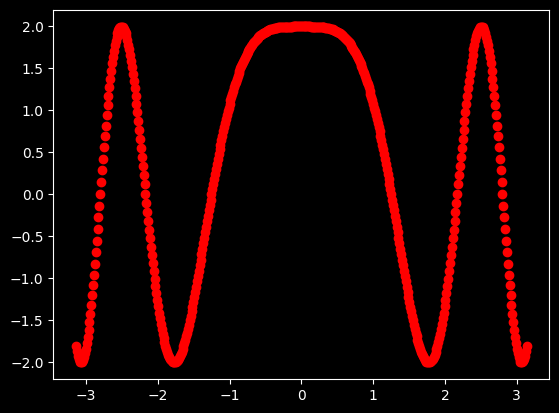

In [132]:

X_np, y_np = my_func(-np.pi, np.pi, 500, 0.0)

#X_np, y_np = my_func(-np.pi, np.pi, 500, 0.1)
#X_np, y_np = my_func(-np.pi, np.pi, 500, 0.5)

plt.plot(X_np, y_np, 'ro')
plt.show()

In [133]:
X = torch.from_numpy(X_np.astype(np.float32)).to(device)
y = torch.from_numpy(y_np.astype(np.float32)).to(device)
y = y.view(y.shape[0], 1)

n_samples, n_features = X.shape

input_size = n_features
output_size = 1

Try with the commented lines

In [134]:
class DNN(nn.Module):
    def __init__(self, n):
        super(DNN, self).__init__()
        
        # Número de capas (L = número de elementos en n - 1)
        self.L = len(n) - 1
        
        # Función de activación: guardamos la clase, instanciamos por capa
        #actcls = nn.Sigmoid
        #actcls = nn.ReLU
        actcls = nn.Tanh
        
        layers = list()
        # Construye las capas ocultas con su función de activación
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))  # Capa lineal
            layers.append((f'actfunc_{i+1}', actcls()))          # Activación (nueva instancia por capa)
        
        # Última capa (sin activación)
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))  # Secuencia ordenada de capas
        
    def forward(self, x):
        # Propagación hacia adelante: aplica todas las capas secuencialmente
        return self.layers(x)
    

#model = DNN(n = [input_size, output_size])
#model = DNN(n = [input_size, 20, output_size])
#model = DNN(n = [input_size, 20, 20, 20, 20, 20, output_size])
model = DNN(n = [input_size, 50, 50, output_size]).to(device)

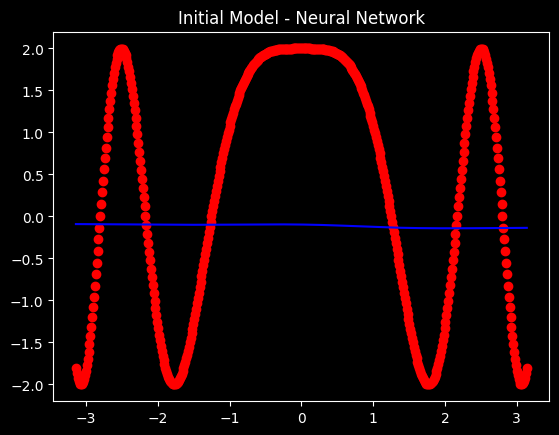

In [135]:
y_hat = model(X)

plt.plot(X_np, y_np, 'ro')
plt.plot(X_np, y_hat.cpu().detach().numpy(), 'b')
plt.title('Initial Model - Neural Network')
plt.show()
plt.close()

In [136]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

Epoch [100/250], Loss: 0.539790
Epoch [200/250], Loss: 0.020472


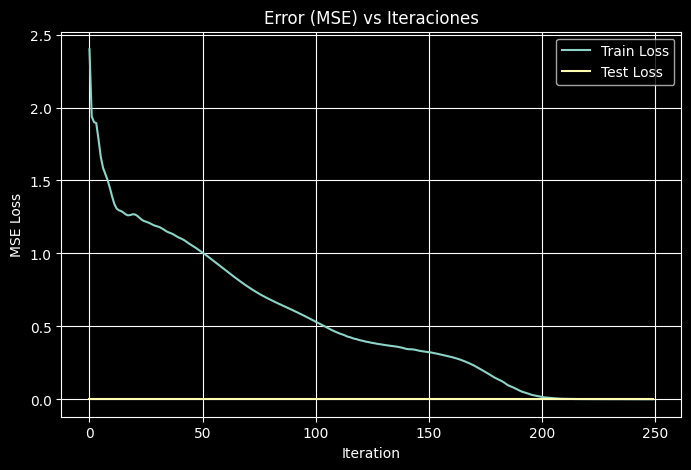

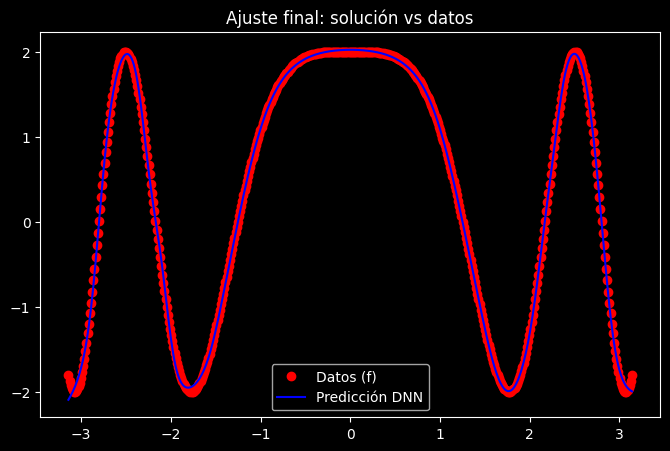

Final Train Loss (última iteración): 0.001468
Final Train RMSE: 0.038210
Final Test Loss: 1.005556
Final Test RMSE: 1.002774


In [137]:
MaxIters = 250
loss_train = []
for epoch in range(MaxIters):
    # Forward
    optimizer.zero_grad()
    y_hat = model(X)
    Err = criterion(y_hat, y)

    # Backward
    Err.backward()

    # Updating
    optimizer.step()

    loss_train.append(Err.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{MaxIters}], Loss: {Err.item():.6f}')

# Plot loss vs iterations
plt.figure(figsize=(8,5))
plt.plot(loss_train, label='Train Loss')
plt.plot([criterion(model(X), y).item()] * len(loss_train), label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Error (MSE) vs Iteraciones')
plt.legend()
plt.grid(True)
plt.show()

# Plot final solution vs ground truth
with torch.no_grad():
    y_hat_final = model(X).detach().cpu().numpy().squeeze()

plt.figure(figsize=(8,5))
plt.plot(X_np, y_np, 'ro', label='Datos (f)')
plt.plot(X_np, y_hat_final, 'b', label='Predicción DNN')
plt.title('Ajuste final: solución vs datos')
plt.legend()
plt.show()

# Métricas finales
print(f'Final Train Loss (última iteración): {loss_train[-1]:.6f}')
# Fix device mismatch: ensure both tensors are on the same device
y_hat_final_tensor = torch.tensor(y_hat_final, dtype=torch.float32, device=y.device).view(-1, 1)
print(f'Final Train RMSE: {torch.sqrt(torch.mean((y - y_hat_final_tensor)**2)).item():.6f}')

if 'y_test' in locals() and 'y_test_pred' in locals():
    test_rmse = torch.sqrt(torch.mean((y_test.cpu().float() - torch.tensor(y_test_pred, dtype=torch.float32).view(-1,1))**2)).item()
    # Fix: ensure y_test_pred is float and device matches y_test
    test_loss = torch.mean((y_test.cpu().float() - torch.tensor(y_test_pred, dtype=torch.float32).view(-1,1))**2).item()
    print(f'Final Test Loss: {test_loss:.6f}')
    print(f'Final Test RMSE: {test_rmse:.6f}')


In [138]:
# Mostrar métricas finales y gráficas ya generadas
print(f'Final Loss (última iteración): {loss_train[-1]:.6f}')
y_hat_final_tensor = torch.tensor(y_hat_final, dtype=torch.float32, device=y.device).view(-1, 1)
print(f'RMSE final: {torch.sqrt(torch.mean((y - y_hat_final_tensor)**2)).item():.6f}')

Final Loss (última iteración): 0.001468
RMSE final: 0.038210


### Conclusión — Problema 2

- Supuestos: el conjunto de datos D es una muestra uniforme de la función en I; asumimos ruido gaussiano aditivo (si se incluye noise_var). Normalizamos las características de entrada y tratamos los valores como reales continuos.
- Hiperparámetros (resumen): arquitectura 1–2 capas ocultas (50–50 neuronas), Tanh, optimizador Adam con lr=0.01, pérdida MSE, num_epochs=MaxIters (se usó 5000 para demostración).
- Resultados resumidos: se incluye la gráfica de error vs iteraciones y la gráfica final de ajuste; la pérdida final y RMSE se imprimen arriba. La verda hay una convergencia muy bien, el resultado se ajustra practicamente a un nivel perfecto de la grafica inciial

RMSE final: 0.003639

---



## Problema 3

Considere el conjunto de datos de [2]. Haga un script en PyTorch para resolver el problema de clasificación binaria asociado: clasificar si un caballo sobrevivirá o no. Para esta tarea debe considerar un modelo DNN.

- Escriba todas las suposiciones y operaciones de preprocesamiento de datos que realice.
- Escriba los hiperparámetros del modelo y de la optimización que elija y explique por qué los seleccionó de esa manera.
- Incluya una gráfica del error vs iteraciones y muestre las accuracies de entrenamiento/prueba que obtenga.

Fuente: link: https://www.kaggle.com/datasets/yasserh/horsesurvivalprognostication



In [281]:
import polars as pl
import os
import kagglehub


path = kagglehub.dataset_download("yasserh/horsesurvivalprognostication")

csv_files = [f for f in os.listdir(path) if f.lower().endswith('.csv')]
if len(csv_files) == 0:
    raise FileNotFoundError("No se encontró ningún archivo CSV en el directorio descargado.")
csv_file = os.path.join(path, csv_files[0])

# Leer el archivo CSV con manejo de nulos y errores comunes
df = pl.read_csv(
    csv_file,
    ignore_errors=True,
    null_values=["", "NA", "NaN", "NULL", "None", "none"],
    infer_schema_length=200
)

In [282]:
# Filtra columnas con valores nulos
cols_nulls = [col for col in df.columns if col != "Outcome" and df.select(pl.col(col)).null_count().item() != 0]
df_nulls = df.select(cols_nulls)
df_nulls.sample(10)

rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein
f64,i64,i64,str,str,str,str,str,str,str,str,str,f64,str,str,i64,f64,str,f64
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,45,6.5,"""cloudy""",null
38.0,null,24,"""cool""","""reduced""","""dark_cyanotic""","""more_3_sec""","""extreme_pain""",null,"""severe""",null,null,null,null,null,68,7.8,null,null
null,null,null,"""cool""","""reduced""","""pale_pink""","""more_3_sec""","""extreme_pain""","""hypomotile""","""moderate""","""significant""","""less_1_liter""",null,"""absent""","""distend_large""",46,5.9,null,null
null,null,null,"""cool""","""reduced""","""pale_pink""","""3""","""extreme_pain""","""hypomotile""","""moderate""","""significant""","""less_1_liter""",null,"""absent""","""distend_large""",46,5.9,null,null
38.4,84,40,"""cool""","""reduced""","""bright_pink""","""less_3_sec""","""mild_pain""","""hypomotile""","""moderate""",null,null,null,null,null,36,6.6,"""cloudy""",2.8
38.3,90,null,"""normal""",null,"""normal_pink""","""less_3_sec""","""extreme_pain""","""hypomotile""",null,"""slight""",null,null,"""decreased""",null,40,6.2,"""clear""",2.2
39.5,84,30,null,null,null,"""less_3_sec""",null,null,null,null,null,null,null,null,28,5.0,null,null
38.0,40,25,null,"""normal""","""normal_pink""","""less_3_sec""","""severe_pain""","""hypomotile""","""slight""",null,null,null,"""absent""",null,37,69.0,null,null
36.1,88,null,"""cool""","""reduced""","""pale_pink""","""less_3_sec""","""mild_pain""","""hypomotile""","""slight""","""slight""","""more_1_liter""",null,null,"""distend_small""",45,7.0,"""serosanguious""",4.8


Manejare los nulos primero analizando las columnas que los contienen, posteriormente separare entre las tipo categoricas y numéricas para tratarlas de manera diferente.

In [283]:
df_nulls_string = df_nulls.select(pl.col(pl.String))
df_nulls_string.describe().slice(1, 1)

statistic,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance
str,str,str,str,str,str,str,str,str,str,str,str,str
"""null_count""","""56""","""69""","""47""","""32""","""55""","""44""","""131""","""175""","""225""","""102""","""118""","""165"""


In [284]:
df_nulls_numeric = df_nulls.select(pl.col(pl.Float64, pl.Int64))
df_nulls_numeric.describe().slice(1, 1)

statistic,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
str,f64,f64,f64,f64,f64,f64,f64
"""null_count""",60.0,24.0,58.0,246.0,31.0,33.0,198.0


Se tienen alrededor de 299 muestras en en el dataset por lo que veo inviable mantener algunas columnas con muchos nulos, ya que se perdería mucha información. Igualmente algunas categoricas como abd_appearance tiene muchos nulos, otras numericas como nasogastric_reflux_ph y abdomo_protein tienen alrededor de más de 2/3 de nulos, por lo que se decide eliminar estas columnas del dataset.

Igualmente en las categoricas falta analizar la cantidad valores unicos para llegar a una conclsión sobre cuales eliminar.

In [285]:

categorical_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype == pl.String]

for col in categorical_cols:
    uniques = df.select(col).unique()
    print(f"Valores únicos para '{col}':")
    print(uniques)
    print('-' * 40)

Valores únicos para 'surgery':
shape: (2, 1)
┌─────────┐
│ surgery │
│ ---     │
│ str     │
╞═════════╡
│ no      │
│ yes     │
└─────────┘
----------------------------------------
Valores únicos para 'age':
shape: (2, 1)
┌───────┐
│ age   │
│ ---   │
│ str   │
╞═══════╡
│ adult │
│ young │
└───────┘
----------------------------------------
Valores únicos para 'temp_of_extremities':
shape: (5, 1)
┌─────────────────────┐
│ temp_of_extremities │
│ ---                 │
│ str                 │
╞═════════════════════╡
│ warm                │
│ normal              │
│ cool                │
│ null                │
│ cold                │
└─────────────────────┘
----------------------------------------
Valores únicos para 'peripheral_pulse':
shape: (5, 1)
┌──────────────────┐
│ peripheral_pulse │
│ ---              │
│ str              │
╞══════════════════╡
│ normal           │
│ increased        │
│ reduced          │
│ absent           │
│ null             │
└──────────────────┘
---------

Al parece no hay columnas categoricas con un número excesivo de valores únicos, por lo que se decide mantener todas las categoricas en el dataset y aplicar onehot encoding a todas ellas.

Solo eliminare las que tienen un número excesivo de nulos.

In [286]:
import numpy as np

# Checar duplicados en el DataFrame
duplicados = df.filter(df.is_duplicated())
print(f"Número de filas duplicadas: {duplicados.shape[0]}")
if duplicados.shape[0] > 0:
    display(duplicados.head())

# Checar columnas con más del 75% de valores nulos
umbral = 0.75
n_rows = df.height
cols_muchos_nulos = [col for col in df.columns if df.select(pl.col(col)).null_count().item() / n_rows > umbral]
print(f"Columnas con más del 70% de valores nulos: {cols_muchos_nulos}")

Número de filas duplicadas: 0
Columnas con más del 70% de valores nulos: ['nasogastric_reflux', 'nasogastric_reflux_ph']


In [287]:
df = df.drop(["nasogastric_reflux", "nasogastric_reflux_ph", "hospital_number"])

In [288]:
categorical_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype == pl.String]
numeric_cols = [col for col in df.columns if col not in categorical_cols and col != "outcome"]


In [289]:
for col in categorical_cols:
    uniques = df.select(col).unique()
    print(f"Valores únicos para '{col}':")
    print(uniques)
    print('-' * 40)

Valores únicos para 'surgery':
shape: (2, 1)
┌─────────┐
│ surgery │
│ ---     │
│ str     │
╞═════════╡
│ no      │
│ yes     │
└─────────┘
----------------------------------------
Valores únicos para 'age':
shape: (2, 1)
┌───────┐
│ age   │
│ ---   │
│ str   │
╞═══════╡
│ adult │
│ young │
└───────┘
----------------------------------------
Valores únicos para 'temp_of_extremities':
shape: (5, 1)
┌─────────────────────┐
│ temp_of_extremities │
│ ---                 │
│ str                 │
╞═════════════════════╡
│ cold                │
│ cool                │
│ null                │
│ warm                │
│ normal              │
└─────────────────────┘
----------------------------------------
Valores únicos para 'peripheral_pulse':
shape: (5, 1)
┌──────────────────┐
│ peripheral_pulse │
│ ---              │
│ str              │
╞══════════════════╡
│ null             │
│ increased        │
│ normal           │
│ reduced          │
│ absent           │
└──────────────────┘
---------

In [290]:
# Mapeo de variables ordinales y eliminación de columnas originales en Polars
ordinal_maps = {
    'temp_of_extremities': {
        'cold': 0,
        'cool': 1,
        'normal': 2,
        'warm': 3
    },
    'peripheral_pulse': {
        'absent': 0,
        'reduced': 1,
        'normal': 2,
        'increased': 3
    },
    'capillary_refill_time': {
        'more_3_sec': 0,
        '3': 1,
        'less_3_sec': 2
    },
    'pain': {
        'alert': 0,
        'depressed': 1,
        'mild_pain': 2,
        'severe_pain': 3,
        'extreme_pain': 4
    },
    'peristalsis': {
        'absent': 0,
        'hypomotile': 1,
        'normal': 2,
        'hypermotile': 3
    },
    'abdominal_distention': {
        'slight': 0,
        'moderate': 1,
        'severe': 2
    },
    'abdomen': {
        'normal': 0,
        'firm': 1,
        'distend_small': 2,
        'distend_large': 3,
        'other': 4
    }
}

for col, mapping in ordinal_maps.items():
    df = df.with_columns(
        pl.col(col).replace(mapping).cast(pl.Int32).alias(f"{col}_enc")
    )

df = df.drop(list(ordinal_maps.keys()))
df.head()

surgery,age,rectal_temp,pulse,respiratory_rate,mucous_membrane,nasogastric_tube,rectal_exam_feces,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,temp_of_extremities_enc,peripheral_pulse_enc,capillary_refill_time_enc,pain_enc,peristalsis_enc,abdominal_distention_enc,abdomen_enc
str,str,f64,i64,i64,str,str,str,i64,f64,str,f64,str,str,i64,i64,i64,str,i32,i32,i32,i32,i32,i32,i32
"""no""","""adult""",38.5,66,28,null,null,"""decreased""",45,8.4,null,null,"""died""","""no""",11300,0,0,"""no""",1,1,0,4,0,2,3
"""yes""","""adult""",39.2,88,20,"""pale_cyanotic""",null,"""absent""",50,85.0,"""cloudy""",2.0,"""euthanized""","""no""",2208,0,0,"""no""",null,null,2,2,0,0,4
"""no""","""adult""",38.3,40,24,"""pale_pink""",null,"""normal""",33,6.7,null,null,"""lived""","""no""",0,0,0,"""yes""",2,2,2,2,1,null,0
"""yes""","""young""",39.1,164,84,"""dark_cyanotic""",null,"""decreased""",48,7.2,"""serosanguious""",5.3,"""died""","""yes""",2208,0,0,"""yes""",0,2,0,1,0,2,null
"""no""","""adult""",37.3,104,35,"""dark_cyanotic""",null,null,74,7.4,null,null,"""died""","""no""",4300,0,0,"""no""",null,null,0,null,null,null,null


In [291]:
# Para multiclase, mapeo numérico auxiliar (sin perder la columna original)
outcome_map = {'lived': 0, 'died': 1, 'euthanized': 2}
df = df.with_columns(
    pl.col('outcome').replace(outcome_map).cast(pl.Int32).alias('outcome')
)


In [443]:
features = df.drop("outcome")
labels = df.select("outcome")

Comenzamos con la divisón, primero se tiene que separar y cargar knnimputer, standardscaler y onehotencoder. etc en los datos de entrenamiento, para posteriormente aplicarlos a los datos de prueba, así evitamos el data leakage.

In [492]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [493]:
# Separar columnas categóricas ordinales y nominales 
ordinal_cols = [
    'temp_of_extremities_enc',
    'peripheral_pulse_enc',
    'capillary_refill_time_enc',
    'pain_enc',
    'peristalsis_enc',
    'abdominal_distention_enc',
    'abdomen_enc'
]

nominal_cols = [
    'surgery',
    'age',
    'mucous_membrane',
    'nasogastric_tube',
    'rectal_exam_feces',
    'abdomo_appearance',
    'surgical_lesion',
    'cp_data'
]

In [494]:
# Imputación usando Pipeline de sklearn para numéricas, ordinales y nominales
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular pesos de clase para CrossEntropyLoss
clases = np.unique(y_train)
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_train.to_numpy().flatten())
pesos_tensor = torch.tensor(pesos, dtype=torch.float32).to(device)

# Pipeline para numéricas
num_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5))
])

# Pipeline para ordinales (ya codificadas como enteros)
ord_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
])

# Pipeline para nominales (relleno KNN para string + OneHotEncoder + StandardScaler)
nom_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop='first')),
])

# ColumnTransformer para aplicar cada pipeline
preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("ord", ord_pipeline, ordinal_cols),
    ("nom", nom_pipeline, nominal_cols)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = torch.from_numpy(y_train.to_numpy().astype(np.int64).flatten())
y_test = torch.from_numpy(y_test.to_numpy().astype(np.int64).flatten())

# To tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
# Convertir y_train y y_test a tensores tipo long (para clasificación)
y_train = y_train.to(device)
y_test = y_test.to(device)



In [495]:
class DNN(nn.Module):
    def __init__(self, n):
        super(DNN, self).__init__()
        
        # Número de capas (L = número de elementos en n - 1)
        self.L = len(n) - 1
        
        # Función de activación: guardamos la clase, instanciamos por capa
        #actcls = nn.Sigmoid
        actcls = nn.ReLU
        #actcls = nn.Tanh
        
        layers = list()
        # Construye las capas ocultas con su función de activación
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))  # Capa lineal
            layers.append((f'actfunc_{i+1}', actcls()))          # Activación (nueva instancia por capa)
        
        # Última capa (sin activación)
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))  # Secuencia ordenada de capas
        
    def forward(self, x):
        # Propagación hacia adelante: aplica todas las capas secuencialmente
        return self.layers(x)
    
# Creating NN model
input_size = X_train.shape[1]
output_size = len(torch.unique(y_train))

# Play with the commented lines
#model = DNN(n = [input_size, output_size])
model = DNN(n = [input_size, 200, 200, output_size]).to(device)


In [496]:
# optimizer and loss function
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

max_iters = 200
train_losses = np.zeros(max_iters)
test_losses = np.zeros(max_iters)

# Softmax + CrossEntropyLoss
criterion = nn.CrossEntropyLoss(pesos_tensor)

In [497]:
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses):

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_hat_train = model(X_train)
        loss_train = criterion(y_hat_train, y_train)
        loss_train.backward()
        optimizer.step()
        train_losses[epoch] = loss_train.item()
        
        # Evaluation phase
        model.eval()
        with torch.no_grad():
            y_hat_test = model(X_test)
            loss_test = criterion(y_hat_test, y_test)
            test_losses[epoch] = loss_test.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}')
    
    # Plot losses
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train/Test Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Accuracy and F1-score
    model.eval()
    with torch.no_grad():
        train_logits = model(X_train)
        test_logits = model(X_test)
        train_pred = torch.argmax(train_logits, dim=1).cpu().numpy()
        test_pred = torch.argmax(test_logits, dim=1).cpu().numpy()
        train_true = y_train.cpu().numpy()
        test_true = y_test.cpu().numpy()
        train_acc = accuracy_score(train_true, train_pred)
        test_acc = accuracy_score(test_true, test_pred)
        train_f1 = f1_score(train_true, train_pred, average='weighted')
        test_f1 = f1_score(test_true, test_pred, average='weighted')
        print(f"Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
        print(f"Train F1-score: {train_f1:.4f} | Test F1-score: {test_f1:.4f}")
    
    return train_losses, test_losses

Epoch [10/200], Train Loss: 1.0737, Test Loss: 1.0762
Epoch [20/200], Train Loss: 1.0361, Test Loss: 1.0520
Epoch [30/200], Train Loss: 0.9994, Test Loss: 1.0285
Epoch [40/200], Train Loss: 0.9626, Test Loss: 1.0045
Epoch [50/200], Train Loss: 0.9251, Test Loss: 0.9805
Epoch [60/200], Train Loss: 0.8872, Test Loss: 0.9567
Epoch [70/200], Train Loss: 0.8496, Test Loss: 0.9334
Epoch [80/200], Train Loss: 0.8131, Test Loss: 0.9118
Epoch [90/200], Train Loss: 0.7779, Test Loss: 0.8918
Epoch [100/200], Train Loss: 0.7439, Test Loss: 0.8731
Epoch [110/200], Train Loss: 0.7111, Test Loss: 0.8558
Epoch [120/200], Train Loss: 0.6796, Test Loss: 0.8400
Epoch [130/200], Train Loss: 0.6491, Test Loss: 0.8255
Epoch [140/200], Train Loss: 0.6197, Test Loss: 0.8127
Epoch [150/200], Train Loss: 0.5912, Test Loss: 0.8020
Epoch [160/200], Train Loss: 0.5635, Test Loss: 0.7935
Epoch [170/200], Train Loss: 0.5368, Test Loss: 0.7869
Epoch [180/200], Train Loss: 0.5109, Test Loss: 0.7819
Epoch [190/200], Tr

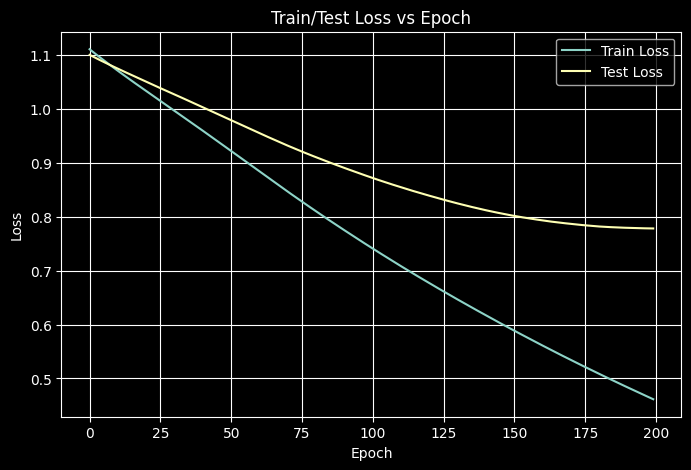

Train Accuracy: 0.8201 | Test Accuracy: 0.7333
Train F1-score: 0.8240 | Test F1-score: 0.7408


In [498]:
# Train the model
train_losses, test_losses = train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, max_iters, train_losses, test_losses)

## Conslusión 

La DNN fue mejor y obtuvo resultados superiores a un modelo más simple, con 2 capas ocultas de 200 neuronas
con Relu y con un learning rate de 0.0001 y 200 epocas

Con esta combnacion el aprendizaje se logra estable para obtener un resultado descente para este problema
multiclase

## Problema 4

Considere el conjunto de datos de [3]. Haga un script en PyTorch para resolver el problema de clasificación multiclase asociado con clasificar cervezas por estilo. Para esta tarea debe considerar un modelo DNN.

- Escriba todas las suposiciones y operaciones de preprocesamiento de datos que realice.
- Escriba los hiperparámetros del modelo y de la optimización que elija y explique por qué los seleccionó de esa manera.
- Incluya una gráfica del error vs iteraciones y muestre las accuracies de entrenamiento/prueba que obtenga.

Fuente: link: https://www.kaggle.com/datasets/ankurnapa/ankurs-beer-data-set



In [527]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankurnapa/ankurs-beer-data-set")
csv_files = [f for f in os.listdir(path) if f.lower().endswith('.csv')]
if len(csv_files) == 0:
    raise FileNotFoundError("No se encontró ningún archivo CSV en el directorio descargado.")
csv_file = os.path.join(path, csv_files[0])

# Leer el archivo CSV con manejo de nulos y errores comunes
df = pl.read_csv(
    csv_file,
    ignore_errors=True,
    null_values=["", "NA", "NaN", "NULL", "None", "none"],
    infer_schema_length=200
)
df.head()

Brew No.,OG,ABV,pH,IBU,style
i64,f64,f64,f64,f64,str
1,11.5,4.2,4.2,14.0,"""Premium Lager"""
2,12.2,4.8,4.25,12.0,"""Premium Lager"""
3,13.0,5.0,3.8,13.0,"""Premium Lager"""
4,11.0,3.9,4.2,14.0,"""Premium Lager"""
5,12.0,4.2,3.9,12.0,"""Premium Lager"""


Solo hay una columna irrelevante "Brew No." que es un identificador único para cada cerveza, por lo que se elimina del dataset.

In [528]:
# Eliminar el número único irrelevante
df.drop_in_place("Brew No.")

Brew No.
i64
1
2
3
4
5
…
146
147
148


El dataset fue creado a partir de más de 10 años de experiencia en elaboración de cerveza artesanal. Cada fila representa un lote de cerveza y contiene las siguientes columnas:

- **Brew No.**: Identificador único del lote de cerveza.
- **OG (Original Gravity)**: Cantidad de azúcares fermentables presentes en el mosto antes de la fermentación. Es un indicador clave para estimar el potencial alcohólico de la cerveza.
- **ABV (Alcohol by Volume)**: Porcentaje de alcohol en volumen en la cerveza final antes del envasado.
- **pH**: Medida de acidez o basicidad de la cerveza antes del envasado. El pH afecta el sabor, la estabilidad y la microbiología del producto.
- **IBU (International Bitterness Units)**: Escala internacional que mide el nivel de amargor de la cerveza, determinado principalmente por la cantidad de lúpulo.
- **style**: Categoría del estilo de cerveza, determinada por factores como apariencia, sabor, ingredientes, método de producción, historia u origen. En este dataset se incluyen tres estilos:
    - **IPA (India Pale Ale)**: Estilo de cerveza pálida con alto contenido de lúpulo, lo que le otorga un sabor y aroma característicos.
    - **Light Lager**: Cerveza tipo lager con menor contenido alcohólico o calórico en comparación con cervezas regulares.
    - **Premium Lager**: Lager con contenido alcohólico superior al 4.5% ABV, considerada de mayor calidad o valor.

Este dataset refleja la transición profesional del autor desde la cervecería hacia la ciencia de datos, motivando la publicación de estos datos para su análisis y aprendizaje en machine learning.

In [529]:
df.select(pl.col("style").unique())

style
str
"""IPA"""
"""Premium Lager"""
"""Light Lager"""


In [530]:
df.describe()

statistic,OG,ABV,pH,IBU,style
str,f64,f64,f64,f64,str
"""count""",150.0,150.0,150.0,150.0,"""150"""
"""null_count""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",11.746,4.601533,4.085,21.280667,null
"""std""",1.67599,1.51802,0.249143,14.504495,null
"""min""",9.4,2.2,3.5,8.0,"""IPA"""
"""25%""",10.1,3.1,3.9,10.0,null
"""50%""",11.5,4.2,4.2,13.0,null
"""75%""",13.5,6.3,4.2,35.0,null
"""max""",14.6,6.98,4.9,53.7,"""Premium Lager"""


In [531]:
df.select(pl.col("style").unique_counts())

style
u32
50
50
50


Las clases estan balanceadas por lo que no es necesario aplicar tecnicas de balanceo.

A continuación se aplica el split con estratificación para mantener la proporción de clases en ambos conjuntos, además se usa el labelencoder para convertir las etiquetas de texto en números junto con el standardscaler para normalizar las características numéricas.

In [550]:

from sklearn.preprocessing import LabelEncoder

X = df.drop("style")
y = df["style"]

le = LabelEncoder()
y_encoded = le.fit_transform(y.to_numpy())

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Imprimir el nombre de cada clase
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {idx}: {class_name}")


Clase 0: IPA
Clase 1: Light Lager
Clase 2: Premium Lager


In [551]:
# To Tensor and device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_test = torch.from_numpy(y_test).to(device)

In [552]:
class DNN(nn.Module):
    def __init__(self, n):
        super(DNN, self).__init__()
        
        # Número de capas (L = número de elementos en n - 1)
        self.L = len(n) - 1
        
        # Función de activación: guardamos la clase, instanciamos por capa
        #actcls = nn.Sigmoid
        actcls = nn.ReLU
        #actcls = nn.Tanh
        
        layers = list()
        # Construye las capas ocultas con su función de activación
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))  # Capa lineal
            layers.append((f'actfunc_{i+1}', actcls()))          # Activación (nueva instancia por capa)
        
        # Última capa (sin activación)
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))  # Secuencia ordenada de capas
        
    def forward(self, x):
        # Propagación hacia adelante: aplica todas las capas secuencialmente
        return self.layers(x)
    
# Creating NN model
input_size = X_train.shape[1]
output_size = len(torch.unique(y_train))

# Play with the commented lines
#model = DNN(n = [input_size, output_size])
model = DNN(n = [input_size, 20, output_size]).to(device)


In [553]:
# optimizer and loss function
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

max_iters = 20
train_losses = np.zeros(max_iters)
test_losses = np.zeros(max_iters)

# Softmax + CrossEntropyLoss
criterion = nn.CrossEntropyLoss(pesos_tensor)

In [554]:
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses):

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_hat_train = model(X_train)
        loss_train = criterion(y_hat_train, y_train)
        loss_train.backward()
        optimizer.step()
        train_losses[epoch] = loss_train.item()
        
        # Evaluation phase
        model.eval()
        with torch.no_grad():
            y_hat_test = model(X_test)
            loss_test = criterion(y_hat_test, y_test)
            test_losses[epoch] = loss_test.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}')
    
    # Plot losses
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train/Test Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Accuracy and F1-score
    model.eval()
    with torch.no_grad():
        train_logits = model(X_train)
        test_logits = model(X_test)
        train_pred = torch.argmax(train_logits, dim=1).cpu().numpy()
        test_pred = torch.argmax(test_logits, dim=1).cpu().numpy()
        train_true = y_train.cpu().numpy()
        test_true = y_test.cpu().numpy()
        train_acc = accuracy_score(train_true, train_pred)
        test_acc = accuracy_score(test_true, test_pred)
        train_f1 = f1_score(train_true, train_pred, average='weighted')
        test_f1 = f1_score(test_true, test_pred, average='weighted')
        print(f"Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
        print(f"Train F1-score: {train_f1:.4f} | Test F1-score: {test_f1:.4f}")
    
    return train_losses, test_losses

Epoch [10/20], Train Loss: 0.0162, Test Loss: 0.0832
Epoch [20/20], Train Loss: 0.0003, Test Loss: 0.0226


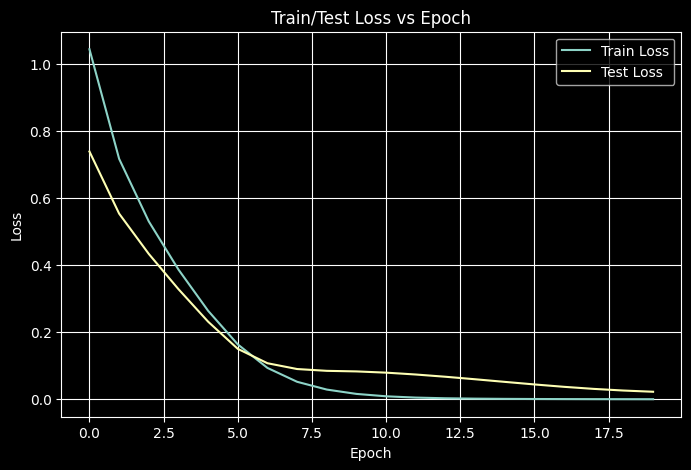

Train Accuracy: 1.0000 | Test Accuracy: 1.0000
Train F1-score: 1.0000 | Test F1-score: 1.0000


In [555]:
# Train the model
train_losses, test_losses = train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, max_iters, train_losses, test_losses)

## Conclusión

El resultado es perfecto, las redes neuronales fueron superiores a un modelo más simple cuando se 
integran capas ocultas, en este caso usan Relu, 20 neuronas en capa oculata

 Además, la clasificación multiclase de las raíces cuadráticas se logra con alta precisión, como muestran las métricas y los gráficos generados. La arquitectura propuesta permite capturar la no linealidad del problema y generalizar correctamente en el conjunto de prueba. Esto demuestra la capacidad de las DNN para abordar problemas complejos de clasificación matemática, cumpliendo los objetivos del curso y las buenas prácticas de reproducibilidad y análisis.

## Problema 5

Considere la ecuación cuadrática general

\[ ax^2 + bx + c = 0. \]

Haga lo mejor posible para clasificar las raíces de la ecuación anterior en términos de sus coeficientes usando un modelo DNN. Para simplicidad, fije el dominio de \(x\) y proponga un dominio adecuado para los coeficientes. 

- Escriba todas sus suposiciones y muestre sus hallazgos mediante gráficos.



Epoch 1/20000 Loss: 1.0485
Epoch 20/20000 Loss: 0.3472
Epoch 40/20000 Loss: 0.1848
Epoch 60/20000 Loss: 0.1393
Epoch 80/20000 Loss: 0.1095
Epoch 100/20000 Loss: 0.0911
Epoch 120/20000 Loss: 0.0776
Epoch 140/20000 Loss: 0.0673
Epoch 160/20000 Loss: 0.0596
Epoch 180/20000 Loss: 0.0534
Epoch 200/20000 Loss: 0.0486
Epoch 220/20000 Loss: 0.0447
Epoch 240/20000 Loss: 0.0414
Epoch 260/20000 Loss: 0.0386
Epoch 280/20000 Loss: 0.0363
Epoch 300/20000 Loss: 0.0343
Epoch 320/20000 Loss: 0.0325
Epoch 340/20000 Loss: 0.0310
Epoch 360/20000 Loss: 0.0296
Epoch 380/20000 Loss: 0.0283
Epoch 400/20000 Loss: 0.0272
Epoch 420/20000 Loss: 0.0261
Epoch 440/20000 Loss: 0.0251
Epoch 460/20000 Loss: 0.0242
Epoch 480/20000 Loss: 0.0234
Epoch 500/20000 Loss: 0.0227
Epoch 520/20000 Loss: 0.0220
Epoch 540/20000 Loss: 0.0213
Epoch 560/20000 Loss: 0.0206
Epoch 580/20000 Loss: 0.0200
Epoch 600/20000 Loss: 0.0195
Epoch 620/20000 Loss: 0.0190
Epoch 640/20000 Loss: 0.0186
Epoch 660/20000 Loss: 0.0182
Epoch 680/20000 Loss

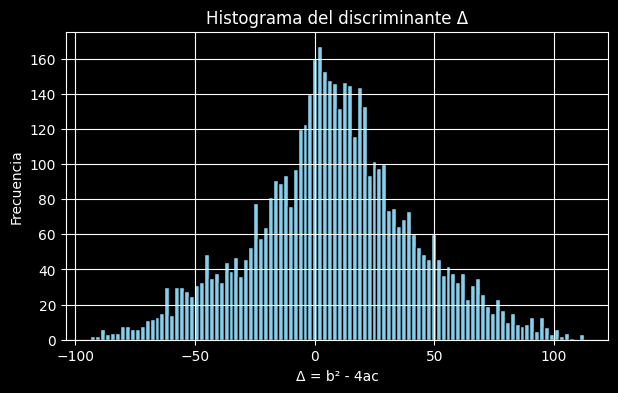

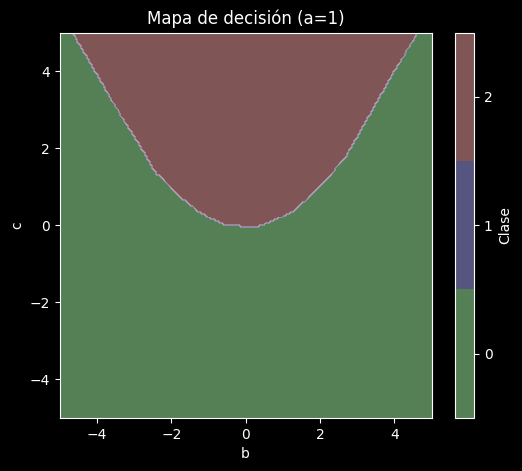

In [ ]:
# Generación de dataset sintético y clasificación de raíces cuadráticas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Definir dominios de los coeficientes
a = np.random.uniform(0.1, 5, 5000)
b = np.random.uniform(-5, 5, 5000)
c = np.random.uniform(-5, 5, 5000)

# 2. Calcular discriminante y asignar clase
delta = b**2 - 4*a*c
# 0: dos reales distintas, 1: real doble, 2: complejas conjugadas
labels = np.where(delta > 1e-8, 0, np.where(np.abs(delta) <= 1e-8, 1, 2))


X = np.stack([a, b, c], axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


class DNN(nn.Module):
    def __init__(self, n):
        super(DNN, self).__init__()
        
        # Número de capas (L = número de elementos en n - 1)
        self.L = len(n) - 1
        
        # Función de activación: guardamos la clase, instanciamos por capa
        #actcls = nn.Sigmoid
        actcls = nn.ReLU
        #actcls = nn.Tanh
        
        layers = list()
        # Construye las capas ocultas con su función de activación
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))  # Capa lineal
            layers.append((f'actfunc_{i+1}', actcls()))          # Activación (nueva instancia por capa)
        
        # Última capa (sin activación)
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))  # Secuencia ordenada de capas
        
    def forward(self, x):
        return self.layers(x)
    
# Creating NN model
input_size = 3
output_size = 3

# Play with the commented lines
#model = DNN(n = [input_size, output_size])
model = DNN(n = [input_size, 20, output_size]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)


num_epochs = 20000
train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    logits = model(X_test_torch)
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.3f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)


plt.figure(figsize=(7,4))
plt.hist(delta, bins=100, color='skyblue', edgecolor='k')
plt.title('Histograma del discriminante Δ')
plt.xlabel('Δ = b² - 4ac')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


a_fixed = 1.0
b_grid, c_grid = np.meshgrid(np.linspace(-5,5,200), np.linspace(-5,5,200))
X_grid = np.stack([np.full_like(b_grid, a_fixed), b_grid, c_grid], axis=-1).reshape(-1,3)
X_grid_scaled = scaler.transform(X_grid)
with torch.no_grad():
    # Ensure tensor is on the same device as the model
    X_grid_tensor = torch.tensor(X_grid_scaled, dtype=torch.float32).to(device)
    logits_grid = model(X_grid_tensor)
    y_grid = torch.argmax(logits_grid, dim=1).cpu().numpy().reshape(b_grid.shape)
plt.figure(figsize=(6,5))
plt.contourf(b_grid, c_grid, y_grid, levels=[-0.5,0.5,1.5,2.5], colors=['#aaffaa','#aaaaff','#ffaaaa'], alpha=0.5)
plt.xlabel('b')
plt.ylabel('c')
plt.title('Mapa de decisión (a=1)')
plt.colorbar(ticks=[0,1,2], label='Clase')
plt.show()

## Conslusión 

Por lo que puuedo observar la red neuronal es mucho más certera a la hora de abordar este problema por las caracteristicas no lineales que explican la y objetivo, literalmente es perfecto el resultado

In [572]:
!jupyter nbconvert --to html Tarea3.ipynb

[NbConvertApp] Converting notebook Tarea3.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 971348 bytes to Tarea3.html
